# Sentinel-1/ Sentinel-2 GIF generator

In [1]:
# standard imports to get started

import datetime
import shapely
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import PillowWriter
import ipywidgets as ipyw
import ipyleaflet

import descarteslabs as dl
dl.select_env(dl.GCP_ENVIRONMENT)
from descarteslabs.catalog import Product, Image, properties as p
from descarteslabs.scenes import search
from descarteslabs import workflows as wf

/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


### 1. Callback functions for interactive stack search

In [2]:
class StackSearch:
    """
    Class for interactive Sentinel-1 footprint search
    """
    def __init__(self):
        # Use jet colormap
        self.jet = matplotlib.cm.get_cmap("jet")
        
        # Number of S1 track
        self.tracks = 176
            
        # Report
        self.report = ipyw.HTML(
            value="Burst summary",
            placeholder="Summary stats",
            description="Updated on click",
        )
        
        # Geojson layer
        self.geojson = None
        
    def style_track_color(self, feature):
        """
        Get color using track number
        """
        track = int(feature["id"].split(":")[-1].split("-")[0])
        jj = track // 16 + (track %16) * 11
    
        style = {
            'color': 'black',
            'fillColor': matplotlib.colors.to_hex(self.jet(jj/176)),
            'opacity':0.7,
            'weight':2,
            #'dashArray':'2', 
            'fillOpacity':0.3,
        }
        return style
    
    def search_bursts(self, **kwargs):
        """
        Print summary stats for footprint
        """
        feature=kwargs["feature"]
        pols = ["VV"]
        burst_root = feature["id"].split(":")[-1]
        pol_ids = [burst_root.replace("-VV-", f"-{x}-") for x in pols]

        fimg = Image.get(feature["id"])
        src = search(fimg.geometry, products=["sentinel-1:burstslc:v0"],
                     start_datetime=datetime.datetime(2014,9,1),
                     end_datetime=datetime.datetime.now(),
                     limit=None)
        bb = src[0].filter(lambda x:
            any(key in x.properties.key for key in pol_ids)
        )
    
        result = f"<br>Scenes for {burst_root}: {len(bb)}<br>"
        nscenes = len(bb)
        for ii in range(0, nscenes, 3):
            nmax = min(nscenes, ii+3)
            result += ", ".join([x.properties.acquired[:10] for x in bb[ii:nmax]]) + "<br>"
        self.report.value = result
        
    def show(self, footprints):
        # Create geojson
        df = {
            "type": "FeatureCollection",
            "features": [],
        }

        for fp in footprints:
            feat = {
                "type": "Feature",
                "geometry": fp.geometry.__geo_interface__,
                "id": fp.id,
            }
            df["features"].append(feat)
            
        self.geojson = ipyleaflet.GeoJSON(data = df,
                              style_callback=self.style_track_color,
                              hover_style={'fillColor': 'black' , 'fillOpacity': 0.2},
                              name = 'Footprints')
        self.geojson.on_click(self.search_bursts)
        wf.map.add_layer(self.geojson)
        
    def clear(self):
        wf.map.remove_layer(self.geojson)
        self.report.close()
        self.geojson = None
        self.report = None

### 2. Utils for search insar product and GIF generation

In [3]:
def get_images(geoctx, orbit=None, btemp=12, 
               t0="2021-01-01", t1="2022-01-01",
               bands="coherence", group_by="day"):
    """
    Function to search for S1/ S2 images
    """
    
    # Make strings out of btemp and orbit
    btemp = str(btemp)
    if orbit:
        orbit = "{:03d}".format(orbit)
       
    # Then create image collection
    if bands in ["coherence", "phase"]:
        # This is for InSAR
        insar_ic = wf.ImageCollection.from_id(
            "sentinel-1:insar:ifg:v0", t0, t1
        ).pick_bands(bands).filter(
            lambda x: x.properties["descartes_version"] == "satin-v1_1"
        ).filter(
            lambda x: x.properties["id"].split("-")[-1] == btemp
        )
    elif bands in ["vv", "vh"]:
        # This for backscatter
        insar_ic = wf.ImageCollection.from_id(
            "sentinel-1:sar:sigma0v:v1", t0, t1
        ).pick_bands(bands)
    elif bands in ["rgb"]:
        # This is for Sentinel-2 optical
        # Change cloud fraction as needed for cleaner GIFs as needed
        insar_ic = wf.ImageCollection.from_id(
            "sentinel-2:L1C", t0, t1
        ).filter(
            lambda img: img.properties["cloud_fraction"] < 0.25
        ).pick_bands(["red", "green", "blue"])
    
    # If relative orbit is not None
    # This is for S1 only. Do not provide this for S2
    if orbit:
        insar_ic = insar_ic.filter(
           lambda x: x.properties["id"].split(":")[-1].split("-")[4] == orbit
        )
    
    # Finally group by and mosaic
    if group_by == "day":
        group_by = ("year", "month", "day")
    elif group_by == "month":
        group_by = ("year", "month")
    
    # Group by month for longer timespans and bigger areas for speed
    insar_ic = insar_ic.groupby(
        dates=group_by
    ).mosaic()
    
    insar_coll = insar_ic.inspect(geoctx)
    return insar_coll

In [4]:
class AnimatedGif:
    """
    GIF helper
    """
    def __init__(self, size=(640, 480)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    def add(self, image, label='', clim=[-0.2, 0.8], cmap="jet", **fontargs):
        if image.shape[0] == 1:
            plt_im = plt.imshow(image[0], cmap=cmap, vmin=clim[0], vmax=clim[1], animated=True)
        else:
            plt_im = plt.imshow(np.moveaxis(image, 0, -1)/clim[1],  animated=True)
        plt_txt = plt.text(10, 310, label, **fontargs)
        self.images.append([plt_im, plt_txt])
 
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer=PillowWriter(fps=5))

In [5]:
def make_gif(stack, outname, layer="coherence"):
    if layer=="coherence":
        clim = [0., 1.]
        cmap = "gray"
    elif layer=="phase":
        clim = [-np.pi, np.pi]
        cmap = "hsv"
    elif layer in ["vv", "vh"]:
        # In dB
        clim = [-20., 1.]
        cmap = "gray"
    elif layer in ["rgb"]:
        clim = [0.0, 0.3]
        cmap = None
    
    try:
        # If grouping by date
        dates = ["{}-{:02d}-{:02d}".format(*x["group"]) for x in stack.properties]
    except:
        # If grouping by month
        dates = ["{}-{:02d}".format(*x["group"]) for x in stack.properties]

    # Grab the data and fill missing data with zero
    data = stack.ndarray.filled(0.)
    
    # data is always 3D / 4D
    m = data.shape[2]
    n = data.shape[3]
    fontargs = {"fontsize": "large",
                "color": "red",
                "backgroundcolor": "white"}
    animated_gif = AnimatedGif(size=(m, n))
    for ii in range(data.shape[0]):
        label = dates[ii]
        M = data[ii, :, :, :]
        animated_gif.add(M,
                         label=label,
                         clim=clim,
                         cmap=cmap, **fontargs)
 
    animated_gif.save(outname)

### 3. Setup AOI using viewport

In [6]:
wf.map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [7]:
# This is for selecting AOI
# On execution the map will center at the right zoom level and you get to see spatial extent of the GIF
wf.map.center = (35.687, -105.9378)
wf.map.zoom = 14

In [8]:
# Scroll around and ensure extent is right before running this cell
poly = shapely.geometry.box(*(wf.map.geocontext().bounds))
zoom = wf.map.zoom
poly.wkt

'POLYGON ((-105.90837478637697 35.6686628958419, -105.90837478637697 35.70540165731956, -105.96725463867189 35.70540165731956, -105.96725463867189 35.6686628958419, -105.90837478637697 35.6686628958419))'

### 4. Identify unique S1 burst footprints in viewport

If you know the track number, just skip this section and use the track number in the next section

In [ ]:
# Search for footprints that intersect with AOI
footprints = Product.get("sentinel-1:burstindex:v0").images().intersects(poly)
print("Number of burst footprints: ", footprints.count())
print("Number of tracks: ", len(set([x.id.split(":")[-1].split("-")[0] for x in footprints])))

In [ ]:
# Set up stack search
srch = StackSearch()

In [ ]:
# Display outlines of bursts on map
srch.show(footprints)

In [ ]:
# Display report on number of bursts per footprint
display(srch.report)

In [ ]:
# This clears out burst footprints
srch.clear()

### 5. Create GIF

In [9]:
# This sets up projection and resolution at which data will be pulled in
epsg=32601 + int((poly.centroid.xy[1][0] + 180)/6)
geoctx = wf.GeoContext(bounds=poly.bounds, crs=f"EPSG:{epsg}", resolution=20., align_pixels=True)

In [14]:
# Pull in backscatter data
coll = get_images(geoctx, orbit=158, t0="2022-01-01", t1="2023-02-01", bands="vv", group_by="month")

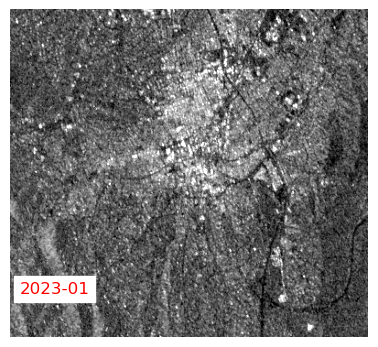

In [15]:
# Make the backscatter GIF
make_gif(coll, "SantaFe_VV_T158_2022_2023.gif", layer="vv")

In [16]:
# Pull in coherence date
coll = get_images(geoctx, orbit=158, btemp=12, t0="2022-01-01", t1="2023-02-01", bands="coherence")

/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/workflows/inspect/client.py:212: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  **arguments,


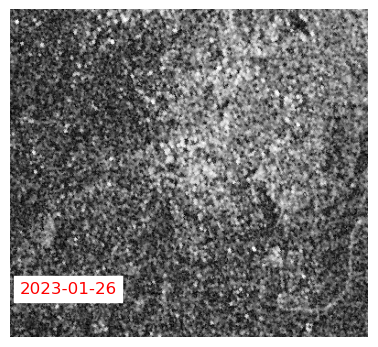

In [17]:
# Make coherence gif
make_gif(coll, "SantaFe_coh_T158_2022_2023.gif", layer="coherence")

In [18]:
# Pull S2 data
coll = get_images(geoctx, t0="2022-01-01", t1="2023-02-01", bands="rgb", group_by="month")

/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/workflows/inspect/client.py:212: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  **arguments,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

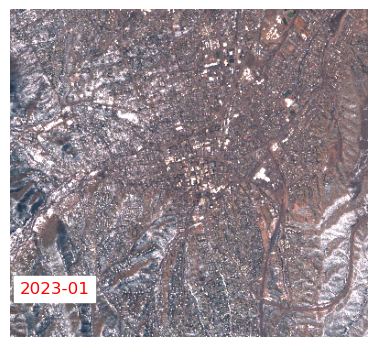

In [19]:
# Make S2 gif
make_gif(coll, "SantaFe_S2_2022_2023.gif", layer="rgb")